# Artificial Intelligence - PBL3
## :: Finding Genes that Affect Breast Cancer
### 정 병길 (ByeongGil Jung)

---

# [ Contents ]
### 1. Introduction
### 2. Preprocessing Dataset
### 3. Finding the Best Claissifier
### 4. Selecting Features
### 5 - 1. Cutting Features using SBS
#### - (1) Finding Best Features
#### - (2) Selecting More Influential Features
### 5 - 2. Compressing Features using PCA
### 6. Summary
### 7. Conclusion
### + Found Influential Genes

---

# 1. Introduction

About 10 percent of women around the world have breast cancer after age 40.  
Thus, treatment and prevention of breast cancer is a worldwide study issue, and many researchers have tried to find a gene that affects breast cancer.  
I'll also find genes that have an influential impact on breast cancer through machine learning and then I'll contribute to their research.  
  
A total of 363 patient data and a total of 19560 genetic information data were given.  
I will draw results from these data.

---

# 2. Preprocessing Dataset

The features to train are "Genes", and labels are "Grade".  
Because "Grade" is better distributed and clear than "Stage".

### Reading Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math

file = r"./breatcancer_expr.xls"
expr_original = pd.read_excel(file, index_col=0)
file = r"./breatcancer_clinical.xls"
original_clinical = pd.read_excel(file, index_col=0)

### Removing the 'Patient Number' of 'clinical' not presented in 'expr'

To match the samples of two dataframes equally.

In [2]:
duplicated_expr = expr_original.T

# Removing the 'Patient Number' of 'clinical' not present in 'expr'
dummy_gsm_list = list()
for gsm in original_clinical.index.values:
    if not gsm in expr_original.columns.values:
        dummy_gsm_list.append(gsm)

dummy_gsm = original_clinical.loc[dummy_gsm_list]

clinical_non_preprocessed = original_clinical.drop(dummy_gsm_list, axis=0)
clinical_preprocessed = clinical_non_preprocessed.drop(
    ["treatment", "node.status", "microarray", "time.drfs", "time.dfs", "time.dmfs", "time.dss", "event.drfs", "event.dfs", "event.dmfs", "event.dss"],
    axis=1)

### Converting redundant data into one data that is their mean value

In [3]:
unduplicated_gene_list = list(set(duplicated_expr.columns))
expr_unduplicated_dict = dict()

# Converting redundant data into one data that is their mean value
for gene in unduplicated_gene_list:
    # If it has redundant data
    if type(duplicated_expr[gene]) is pd.DataFrame:
        expr_unduplicated_dict[gene] = list(duplicated_expr[gene].mean(axis=1))
    # If it doesn't have redundant data
    elif type(duplicated_expr[gene]) is pd.Series:
        expr_unduplicated_dict[gene] = list(duplicated_expr[gene])
        
expr_preprocessed = pd.DataFrame.from_dict(expr_unduplicated_dict)

expr_preprocessed["genename"] = duplicated_expr.index.values
expr_preprocessed = expr_preprocessed.set_index("genename")

# Delete unnecessary data
del unduplicated_gene_list
del expr_unduplicated_dict

### Removing 'Patient Number' where grade doesn't exist

In [4]:
not_exist_grade_gsm_list = list()

for row in clinical_preprocessed.itertuples():
    if math.isnan(row.grade):
        not_exist_grade_gsm_list.append(row.Index)

clinical_preprocessed = clinical_preprocessed.drop(not_exist_grade_gsm_list, axis=0)
expr_preprocessed = expr_preprocessed.drop(not_exist_grade_gsm_list, axis=0)

### Checking preprocessed datasets

In [5]:
print("Preprocessed dataset size of clinical : {}".format(len(clinical_preprocessed)))
clinical_preprocessed.head()

Preprocessed dataset size of clinical : 246


,dataset,sample.id,cohort,er.status,age,stage,size,grade,time.rfs,time.os,time.mfi,event.rfs,event.os,event.mfi
gsm,,,,,,,,,,,,,,
gsm282373,gse11121,BC6001_r,Mainz,0.0,53.926027,1.0,1.8,2.0,7.660274,9.306667,7.660000,1.0,True,1.0
gsm282374,gse11121,BC6002_r,Mainz,1.0,54.375343,2.0,2.5,3.0,7.852055,7.851667,7.851667,0.0,False,0.0
gsm282376,gse11121,BC6004_r,Mainz,1.0,71.260274,1.0,1.2,2.0,0.413699,5.706667,5.706667,1.0,True,0.0
gsm282378,gse11121,BC6006,Mainz,1.0,60.684931,1.0,1.8,2.0,7.783562,7.783333,7.783333,0.0,False,0.0
gsm282379,gse11121,BC6007,Mainz,1.0,60.120548,1.0,1.4,2.0,9.265753,9.265833,9.265833,0.0,False,0.0


In [6]:
print("Preprocessed dataset size of expr : {}".format(len(clinical_preprocessed)))
expr_preprocessed.head()

Preprocessed dataset size of expr : 246


,TMEM268,CHMP2A,ASNSD1,CCPG1,SPG7,SETDB1,HNRNPUL2,EIF3I,S100B,PAF1,...,RHOQ,FPGS,MCM9,CUZD1,DUSP3,EIF3D,ITGB2,APBB1IP,HLCS,MAPK6
genename,,,,,,,,,,,,,,,,,,,,,
gsm282373,7.391904,9.811831,9.831464,6.643132,7.748629,7.693319,8.409267,10.632166,5.797750,8.186369,...,9.112374,9.077241,5.593590,6.091332,7.462369,11.178728,8.767770,6.390205,6.780615,9.414664
gsm282374,8.299415,10.819485,9.769051,7.458986,8.874395,7.389527,7.921330,11.160329,5.539006,8.805052,...,8.337275,9.172549,5.607747,5.895073,7.681999,11.358831,8.678156,6.268270,6.998711,9.523449
gsm282376,8.023669,10.508557,9.293303,7.073523,8.111837,8.025840,7.923042,10.681313,5.847708,8.530828,...,9.164766,9.140068,5.402408,6.132182,7.450148,10.595626,8.651415,6.370019,6.556469,9.483829
gsm282378,7.293001,10.658883,9.379184,7.434434,8.430463,7.682101,7.820901,10.633181,5.907642,8.552980,...,8.852712,8.737543,5.261686,5.798048,7.840317,11.156821,9.488193,6.175462,6.952091,10.031309
gsm282379,8.195598,10.685418,9.588414,7.360994,9.211778,7.700940,7.650343,10.874364,5.561449,9.060590,...,9.051355,8.818063,5.533715,5.715036,8.067445,10.614843,9.550061,6.330468,6.733472,9.448204


---

# 3. Finding the Best Classifier

### Splitting and Scaling Dataset

The ratio between the training set and the testing set is 8 : 2.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import time


X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    expr_preprocessed, 
    list(clinical_preprocessed["grade"]), 
    test_size=0.2, 
    random_state=1
)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_all_std = scaler.fit_transform(X_train_all)
X_test_all_std = scaler.transform(X_test_all)

---

It will be used 'Linear SVM' and 'Logistic Regression' that can use regularization.  
By using regularization, it is possible to remove  features whose weight converges to 0.  
Thus, only influential features can be trained.

### Logistic Regression (L1 Regularization)

In [9]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

total_start = time.time()

clf_lr = LogisticRegression(penalty="l1")
clf_lr.fit(X_train_all_std, y_train_all)

total_end = time.time()

prediction_lr_all = clf_lr.predict(X_test_all_std)
acc_lr = accuracy_score(prediction_lr_all, y_test_all)
lr_elapsed_time = total_end - total_start

lr_scores = cross_val_score(estimator=clf_lr,
                             X=X_train_all_std,
                             y=y_train_all,
                             cv=5,
                             scoring='accuracy')



print("Accuracy (Logistic Regression(l1)) : {}".format(acc_lr))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (lr_scores.mean(), lr_scores.std()))
print("Elapsed Time : {}".format(lr_elapsed_time))

Accuracy (Logistic Regression(l1)) : 0.66
K-Fold scores: 0.63 (+/- 0.05)
Elapsed Time : 0.5017123222351074


### Linear SVM (L1 Regularization)

In [10]:
# SVM(Linear)
from sklearn.svm import LinearSVC

total_start = time.time()

clf_svm_linear = LinearSVC(penalty="l1", dual=False)
clf_svm_linear.fit(X_train_all_std, y_train_all)

total_end = time.time()

pred_svm_linear = clf_svm_linear.predict(X_test_all_std)
acc_svm_linear = accuracy_score(pred_svm_linear, y_test_all)
svm_elapsed_time = total_end - total_start

svm_linear_scores = cross_val_score(estimator=clf_svm_linear,
                                     X=X_train_all_std,
                                     y=y_train_all,
                                     cv=5,
                                     scoring='accuracy')

print("Accuracy (Linear SVM (l1)) : {}".format(acc_svm_linear))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (svm_linear_scores.mean(), svm_linear_scores.std()))
print("Elapsed Time : {}".format(svm_elapsed_time))

Accuracy (Linear SVM (l1)) : 0.62
K-Fold scores: 0.61 (+/- 0.06)
Elapsed Time : 0.563493013381958


### Finding the Best Parameter of LR using GridSearch

In [11]:
# Grid Search (Logistic Regression)
from sklearn.model_selection import GridSearchCV


clf_lr_gs = LogisticRegression()

C_range = [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
tol_range = [0.001, 0.0001, 0.00001]

param_grid = {
    "C": C_range,
    "tol": tol_range,
    "penalty": ["l1"]
}

gs_lr = GridSearchCV(estimator=clf_lr_gs,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=10,
                  n_jobs=-1)

start = time.time()
gs_lr = gs_lr.fit(X_train_all_std, y_train_all)
end = time.time()

print("Elapsed Time : {}".format(end - start))

Elapsed Time : 114.56072068214417


In [12]:
# gs_lr_reuslt = gs_lr.cv_results_
# gs_lr_reuslt

In [13]:
gs_lr.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
clf_lr_best = gs_lr.best_estimator_

start = time.time()
clf_lr_best.fit(X_train_all_std, y_train_all)
end = time.time()

prediction_lr_best = clf_lr_best.predict(X_test_all_std)
acc_lr_best = accuracy_score(prediction_lr_best, y_test_all)
best_lr_elapsed_time = end - start

print("Accuracy (Linear Regression(l1) [Best Params]) : {}".format(acc_lr_best))
print("Elapsed Time : {}".format(best_lr_elapsed_time))

Accuracy (Linear Regression(l1) [Best Params]) : 0.68
Elapsed Time : 0.42688655853271484


### Finding the Best Parameter of Linear SVM using GridSearch

In [15]:
# Grid Search (Linear SVM)
clf_svm_gs = LinearSVC()

C_range = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]
tol_range = [0.001, 0.0001, 0.00001]

param_grid = {
    "C": C_range,
    "tol": tol_range,
    "penalty": ["l1"],
    "dual": [False]
}

gs_svm_linear = GridSearchCV(estimator=clf_svm_gs,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=10,
                  n_jobs=-1)

start = time.time()
gs_svm_linear = gs_svm_linear.fit(X_train_all_std, y_train_all)
end = time.time()

print("Elapsed Time : {}".format(end - start))

Elapsed Time : 110.83767485618591


In [16]:
# gs_svm_linear_result = gs_svm_linear.cv_results_
# gs_svm_linear_result

In [17]:
gs_svm_linear.best_estimator_

LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [18]:
clf_svm_linear_best = gs_svm_linear.best_estimator_

start = time.time()
clf_svm_linear_best.fit(X_train_all_std, y_train_all)
end = time.time()

svm_linear_best_scores = cross_val_score(estimator=clf_svm_linear_best,
                                         X=X_train_all_std,
                                         y=y_train_all,
                                         cv=5,
                                         scoring='accuracy')

prediction_svm_linear_best = clf_svm_linear_best.predict(X_test_all_std)
acc_svm_linear_best = accuracy_score(prediction_svm_linear_best, y_test_all)
best_svm_elapsed_time = end - start

print("Accuracy (Linear SVM(l1) [Best Params]) : {}".format(acc_svm_linear_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (svm_linear_best_scores.mean(), svm_linear_best_scores.std()))
print("Elapsed Time : {}".format(best_svm_elapsed_time))

Accuracy (Linear SVM(l1) [Best Params]) : 0.78
K-Fold scores: 0.62 (+/- 0.03)
Elapsed Time : 0.5036532878875732


### Comparing Classifiers

In [19]:
print("Accuracy (Linear Regression(l1) [Best Params]) : {}".format(acc_lr_best))
print("Accuracy (Linear SVM(l1) [Best Params]) : {}".format(acc_svm_linear_best))

Accuracy (Linear Regression(l1) [Best Params]) : 0.68
Accuracy (Linear SVM(l1) [Best Params]) : 0.78


Because with using the best parameters,  
the accuracy of 'Linear SVM' is higher than 'Logistic Regression'.  
  
__So it would be better to using 'Linear SVM'__

---

# 4. Selecting Features

### The Best Classifier Achived from Above

In [20]:
total_start = time.time()

clf_cut = LinearSVC(C=0.01, penalty='l1', dual=False)
clf_cut.fit(X_train_all_std, y_train_all)

total_end = time.time()

pred_cut = clf_cut.predict(X_test_all_std)

cut_scores = cross_val_score(estimator=clf_cut,
                             X=X_train_all_std,
                             y=y_train_all,
                             cv=5,
                             scoring='accuracy')

acc_cut_best = accuracy_score(pred_cut, y_test_all)
cut_elapsed_time = total_end - total_start

print("Accuracy (SVM(linear) [Best Params]) : {}".format(acc_cut_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (cut_scores.mean(), cut_scores.std()))
print("Elapsed Time : {}".format(cut_elapsed_time))

Accuracy (SVM(linear) [Best Params]) : 0.78
K-Fold scores: 0.62 (+/- 0.03)
Elapsed Time : 0.31415867805480957


### Selecting Features using SelectFromModel
There is a method that is able to select features based on importance weights.  
This can help to extract only some features that have influences on classifying.  
  
(https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

In [21]:
from sklearn.feature_selection import SelectFromModel

selected_model = SelectFromModel(clf_cut, prefit=True)

In [22]:
X_new = selected_model.transform(expr_preprocessed)
X_new

array([[ 6.56517687,  6.29048487,  7.76694041, ...,  6.65482282,
        11.47590116, 11.20098938],
       [ 6.38748102,  5.83084044,  8.66349759, ...,  7.2317994 ,
        11.62761667, 12.54485307],
       [ 6.52570285,  5.76309416,  8.23637207, ...,  6.86744845,
        10.57575591, 12.05381339],
       ...,
       [ 7.04108248,  5.95445544,  7.6689635 , ...,  7.67888123,
        10.15609325, 10.73652962],
       [ 6.08622   ,  5.93518693,  8.4905972 , ...,  7.61931569,
        10.47664847, 11.63295341],
       [ 6.83496394,  5.90139084,  8.30438621, ...,  7.98565469,
        10.42983526, 12.00765109]])

In [23]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_new, 
    list(clinical_preprocessed["grade"]), 
    test_size=0.2, 
    random_state=1
)

In [24]:
scaler = StandardScaler()
X_train_selected_std = scaler.fit_transform(X_train_selected)
X_test_selected_std = scaler.transform(X_test_selected)

In [25]:
X_train_selected_std

array([[-0.0489471 , -0.13829362,  0.11676119, ..., -0.94490964,
         0.37153647,  1.22882177],
       [-0.09197941,  0.28269211, -0.50188626, ...,  1.05997757,
        -0.20091321, -0.93988241],
       [-0.39538809, -0.32458878,  0.38609192, ...,  0.40964782,
        -1.88709113, -0.07782936],
       ...,
       [-0.11720678, -0.51062822,  1.27856879, ..., -1.76886867,
         1.78379945, -0.18566169],
       [ 1.61197363, -0.3376065 , -1.35563363, ...,  1.45124741,
         1.37277752,  0.56432624],
       [-0.24469271, -0.72149384,  0.07094924, ..., -0.58317555,
        -0.83780651,  1.12154423]])

In [26]:
X_test_selected_std

array([[-7.45716123e-01, -6.00674388e-01,  8.24078150e-02, ...,
        -1.71764181e-01, -2.83773078e-01,  8.54268147e-01],
       [ 1.45622979e+00, -3.39643122e-01,  1.17564868e-02, ...,
         2.05986081e+00, -1.13639242e+00,  4.83203816e-01],
       [-8.48995694e-01, -3.60756629e-01, -6.89476587e-01, ...,
         1.06740666e+00, -2.00270425e-01,  2.50541168e-01],
       ...,
       [-4.59207513e-01,  5.18362285e-01, -2.02237575e-01, ...,
        -1.61395520e+00,  5.14549579e-01, -3.96758213e-01],
       [-8.09987833e-01, -1.22346182e+00, -1.95647597e-03, ...,
        -9.03533284e-01,  1.14124116e+00,  7.55557923e-01],
       [ 5.15926216e-01,  6.96545394e-01, -1.45372823e+00, ...,
        -2.33420819e+00,  1.67060713e+00, -3.51985414e-01]])

In [27]:
print("The number of original features : {}".format(len(X_train_all_std[0])))
print("The number of selected features : {}".format(len(X_train_selected_std[0])))

The number of original features : 13013
The number of selected features : 28


Thanks for the regularization of the 'Linear SVM' and the feature selection function,  
it was possible to find the 28 most influential genes.

### Checking the Accuracy of Selected Features

In [28]:
total_start = time.time()

clf_selected = LinearSVC(C=0.01, penalty='l1', dual=False)
clf_selected.fit(X_train_selected_std, y_train_selected)

total_end = time.time()

selected_scores = cross_val_score(estimator=clf_selected,
                                 X=X_train_selected_std,
                                 y=y_train_selected,
                                 cv=5,
                                 scoring='accuracy')

pred_selected = clf_selected.predict(X_test_selected_std)
acc_selected_best = accuracy_score(pred_selected, y_test_selected)
selected_elapsed_time = total_end - total_start

print("Accuracy (SVM(linear) [Selected Features]) : {}".format(acc_selected_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (selected_scores.mean(), selected_scores.std()))
print("Elapsed Time : {}".format(selected_elapsed_time))

Accuracy (SVM(linear) [Selected Features]) : 0.78
K-Fold scores: 0.64 (+/- 0.04)
Elapsed Time : 0.003988981246948242


In [29]:
print("K-Fold scores (Original Features): %0.2f (+/- %0.2f)"% (cut_scores.mean(), cut_scores.std()))
print("K-Fold scores (Selected Features): %0.2f (+/- %0.2f)"% (selected_scores.mean(), selected_scores.std()))

K-Fold scores (Original Features): 0.62 (+/- 0.03)
K-Fold scores (Selected Features): 0.64 (+/- 0.04)


Because K-Fold score of "Selected Features" is higher than "Original Features",  
__we can confirm that selected features are obviously influential on the 'grade'.__

### Rearranging Dataset with Selected Features

In [30]:
# Checking selected index

select_feature_index_bool_list = selected_model.get_support()
select_feature_index_list = list()

for i in range(len(select_feature_index_bool_list)):
    if select_feature_index_bool_list[i] == True:
        select_feature_index_list.append(i)

print("The index list of selected features : ")
select_feature_index_list

The index list of selected features : 


[46,
 203,
 239,
 380,
 1061,
 1303,
 1648,
 1974,
 2544,
 2815,
 3641,
 4326,
 5994,
 6173,
 7085,
 7449,
 8075,
 9400,
 9412,
 9493,
 9636,
 9782,
 11019,
 11109,
 11893,
 11903,
 12598,
 12968]

In [31]:
expr_selected = expr_preprocessed.iloc[:, select_feature_index_list]

In [32]:
print("Dataset size of selected expr : {}".format(len(expr_selected)))
expr_selected.head()

Dataset size of selected expr : 246


,CD7,LRP8,HEXIM1,TPI1P1,CYBRD1,ERBB4,DFFA,COX7C,MRPL15,BCL11A,...,SCUBE2,HTRA2,CIAO2B,PMP22,SLC25A5,WDR19,CDCA3,TMEM39B,COX5A,MLPH
genename,,,,,,,,,,,,,,,,,,,,,
gsm282373,6.565177,6.290485,7.766940,11.865740,8.661585,5.336498,8.041531,11.125007,10.443782,7.019233,...,6.214857,8.751152,9.799899,9.434325,12.604112,6.966100,7.766534,6.654823,11.475901,11.200989
gsm282374,6.387481,5.830840,8.663498,12.153245,6.243273,8.022628,8.352381,11.119565,9.967522,6.996163,...,6.522683,8.179052,9.821884,8.416905,11.565419,7.822283,7.104476,7.231799,11.627617,12.544853
gsm282376,6.525703,5.763094,8.236372,11.748491,9.298099,6.996714,7.733717,10.992404,9.997511,7.172960,...,7.891156,8.577786,9.396427,10.746947,12.324832,8.135081,7.183301,6.867448,10.575756,12.053813
gsm282378,6.299117,5.854471,8.484568,11.785456,8.432658,7.325697,7.770518,10.621926,10.507935,6.573437,...,11.297015,8.741746,9.380524,11.261228,12.043204,8.068822,7.476550,7.513423,11.228983,11.338357
gsm282379,6.173453,7.039738,8.525260,11.960539,7.053925,7.479351,7.723426,10.765772,11.214975,6.286423,...,10.976449,8.804110,10.251448,10.169798,11.991029,7.727159,8.219365,7.438214,11.140726,11.801398


In [33]:
expr_selected.columns

Index(['CD7', 'LRP8', 'HEXIM1', 'TPI1P1', 'CYBRD1', 'ERBB4', 'DFFA', 'COX7C',
       'MRPL15', 'BCL11A', 'SREK1', 'AC099329.1', 'LAMP3', 'TSC22D3', 'YBX1P1',
       'UBE2C', 'KIF4A', 'SATB1', 'SCUBE2', 'HTRA2', 'CIAO2B', 'PMP22',
       'SLC25A5', 'WDR19', 'CDCA3', 'TMEM39B', 'COX5A', 'MLPH'],
      dtype='object')

Finally, it was possible to extract the names and information of the 28 most influential genes.

### Clustering Selected Features

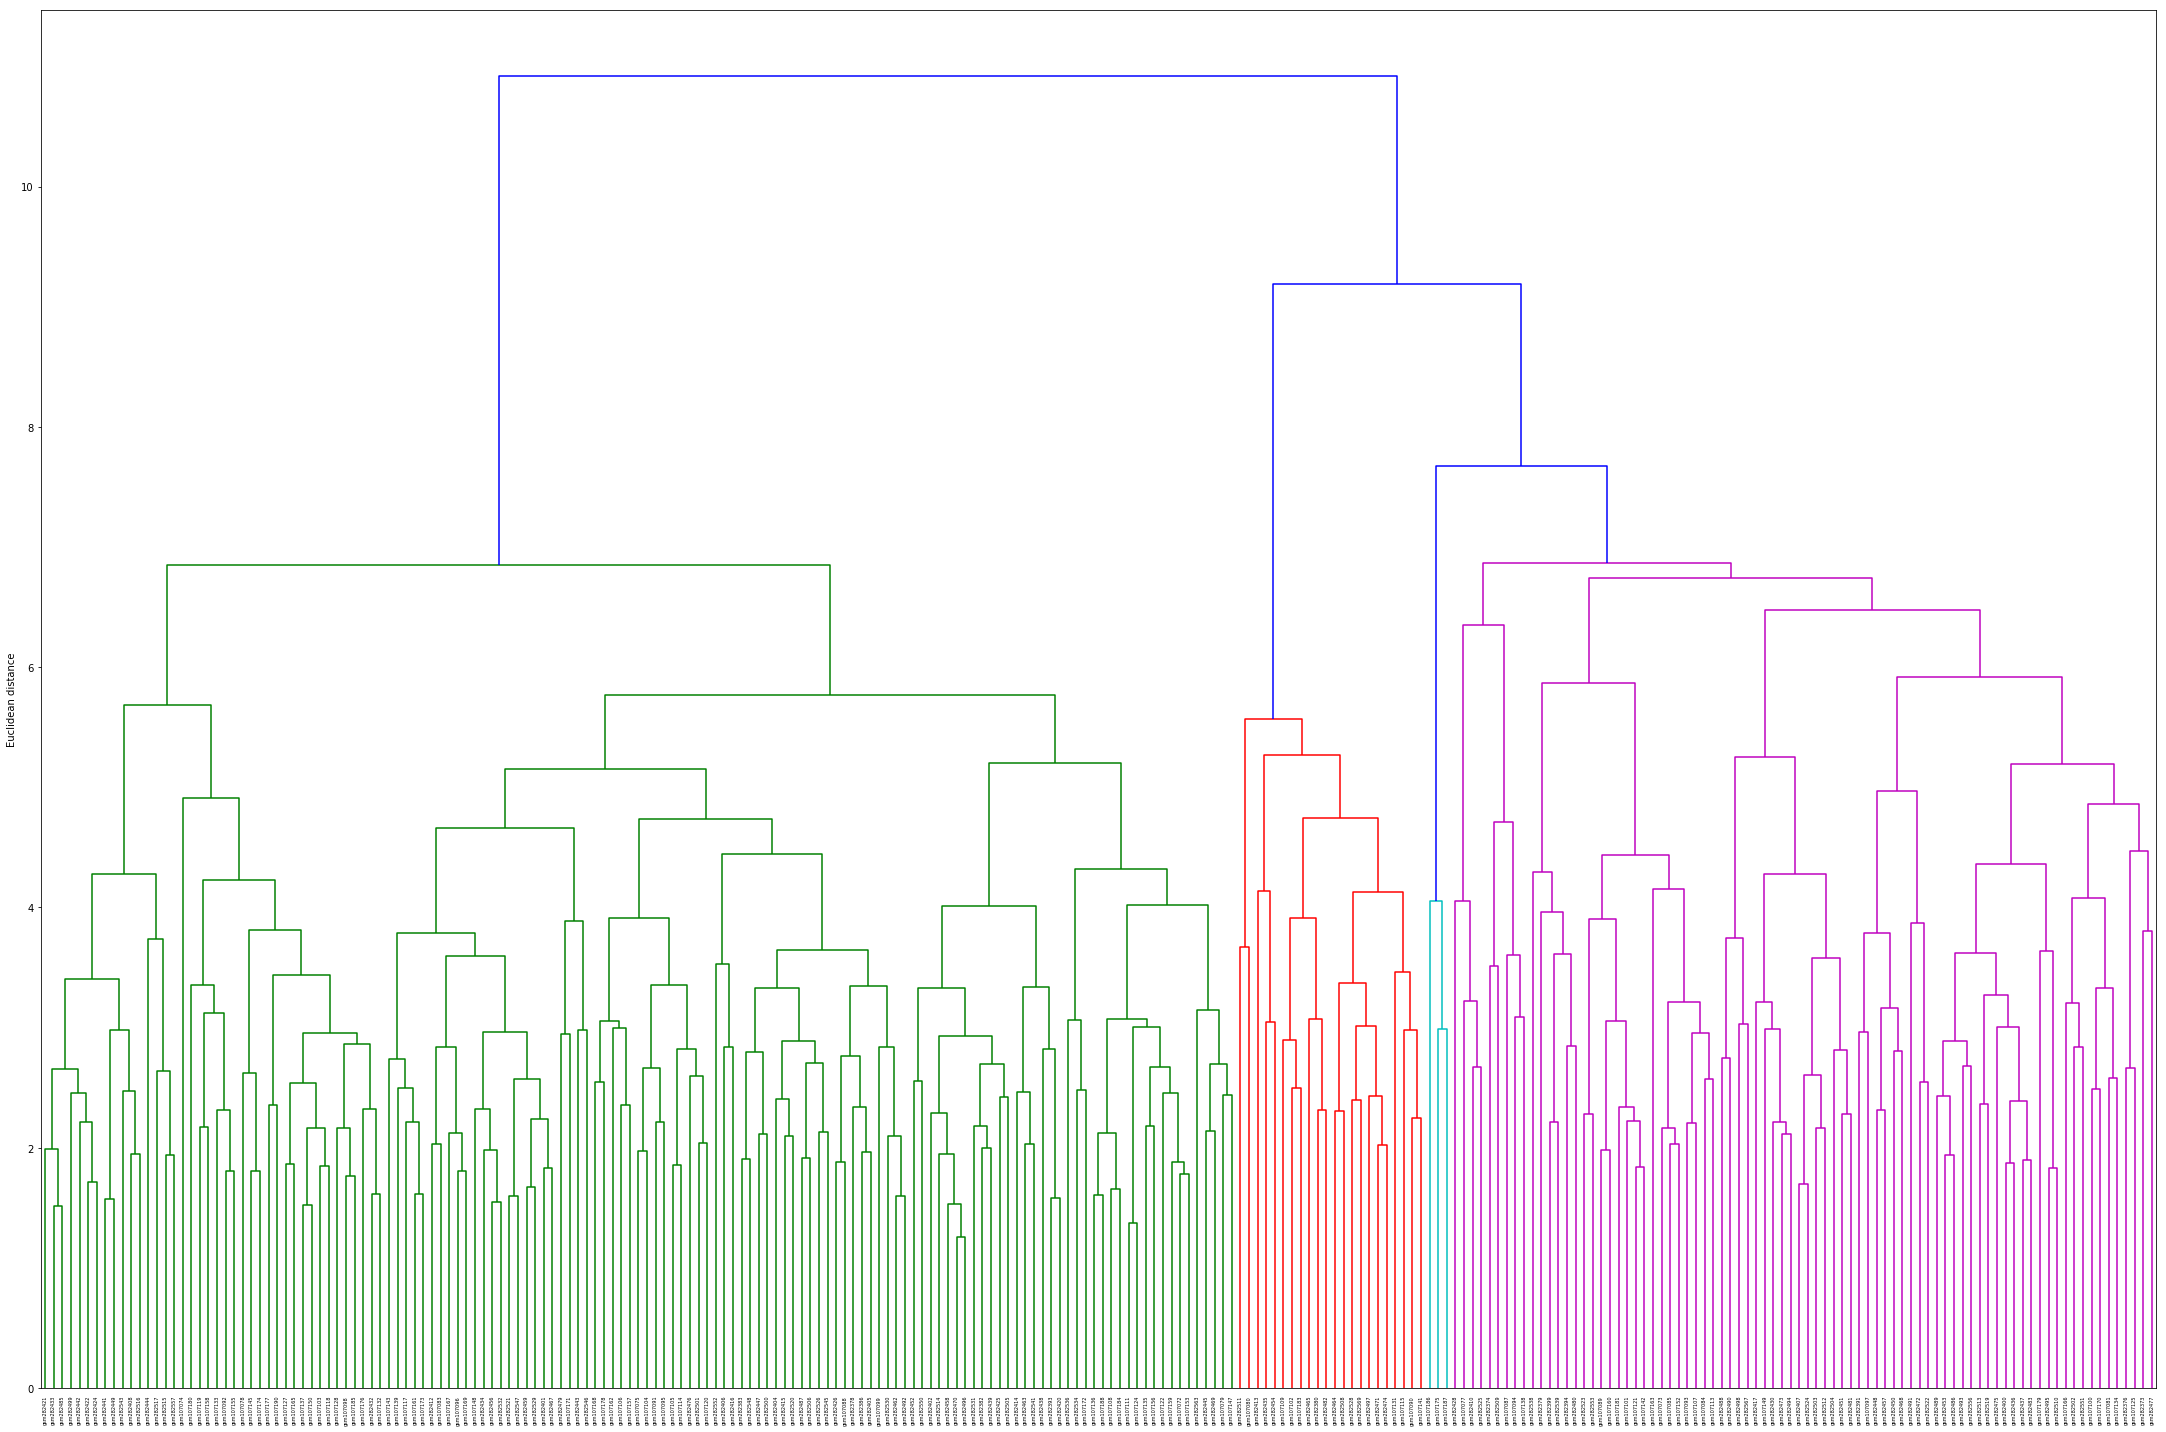

In [34]:
# Clustrering

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from matplotlib.pyplot import figure

plt.figure(figsize=(30, 20))

row_clusters = linkage(pdist(expr_selected, metric='euclidean'), method='complete')
row_dendr = dendrogram(row_clusters, labels=expr_selected.index)

plt.tight_layout()
plt.ylabel('Euclidean distance')

#plt.savefig('./figures/dandrogram.png', dpi=300)
plt.show()

When clustering existing data with selected features,  
we can see that it was divided into about 3 groups.
  
__It is considered that it was classified with 'Grade 1', 'Grade 2', 'Grade 3'.__  
  
In other words, it shows that selected features can classify very well for 'grade'.

---

# 5 - 1. Cutting Features using SBS

To filter out the most influential features among the selected features,  
SBS will be used.

## (1) Finding Best Features

### Using SBS

In [35]:
# SBS

from sklearn.base import clone
from itertools import combinations

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features # desired no. of features
        self.test_size = test_size # validation set
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim)) # current subset of features
        self.subsets_ = [self.indices_] # history of subsets
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score] # history of scores

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

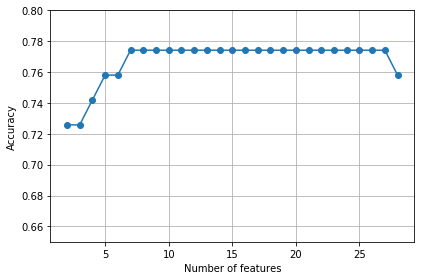

In [36]:
scaler = StandardScaler()
X_selected_std = scaler.fit_transform(X_new)

clf_SBS = LinearSVC(C=0.01, penalty='l1', dual=False)

sbs = SBS(clf_SBS, k_features=2)
sbs.fit(X=X_selected_std, y=list(clinical_preprocessed["grade"]))

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.65, 0.8])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [37]:
sbs.subsets_

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24),
 (0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  23,
  24),
 (0, 2,

It has the most highest accuracy when learning from the top 7 to 27 features.

### Selecting Best Three Features

To confirm clustering of the original data, top three features will be selected.

In [38]:
def get_subset_of_count(subset, count):
    for set_ in subset:
        if len(set_) == count:
            return list(set_)

In [39]:
# selected_list = [8, 6] > 0.76
three_selected_list = get_subset_of_count(sbs.subsets_, 3)

expr_selected.iloc[:, three_selected_list].head()

,AC099329.1,HTRA2,CDCA3
genename,,,
gsm282373,9.794563,8.751152,7.766534
gsm282374,10.843007,8.179052,7.104476
gsm282376,10.258182,8.577786,7.183301
gsm282378,10.442551,8.741746,7.476550
gsm282379,9.785584,8.804110,8.219365


### The Accuracy using Best Three Features

In [40]:
total_start = time.time()

clf_three_selected = LinearSVC(C=0.01, penalty='l1', dual=False)
clf_three_selected.fit(X_train_selected_std[:, three_selected_list], y_train_selected)

total_end = time.time()

pred_three_selected = clf_three_selected.predict(X_test_selected_std[:, three_selected_list])

three_selected_scores = cross_val_score(estimator=clf_three_selected,
                                         X=X_train_selected_std[:, three_selected_list],
                                         y=y_train_selected,
                                         cv=5,
                                         scoring='accuracy')

acc_three_selected_best = accuracy_score(pred_three_selected, y_test_selected)
three_elapsed_time = total_end - total_start

print("Accuracy (SVM(linear) [Best Three Features]) : {}".format(acc_three_selected_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (three_selected_scores.mean(), three_selected_scores.std()))
print("Elapsed Time : {}".format(three_elapsed_time))

Accuracy (SVM(linear) [Best Three Features]) : 0.74
K-Fold scores: 0.66 (+/- 0.03)
Elapsed Time : 0.0009980201721191406


In [41]:
print("The index list :", [three_selected_list[0], three_selected_list[1], three_selected_list[2]])

The index list : [11, 19, 24]


In [42]:
tuple(expr_selected.iloc[:, three_selected_list].columns)

('AC099329.1', 'HTRA2', 'CDCA3')

### Visualization of Clustering using Selected Best Three Features

In [43]:
def draw_two_features(data, index_list):
    plt.figure(figsize=(8, 6), dpi=80)
    feature_name = (data.iloc[:, index_list].columns)
    
    grade_1_expr = data[clinical_preprocessed["grade"] == 1]
    grade_2_expr = data[clinical_preprocessed["grade"] == 2]
    grade_3_expr = data[clinical_preprocessed["grade"] == 3]

    # Grade 1
    xf = grade_1_expr.iloc[:, index_list[0]]
    yf = grade_1_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="grey", label="Grade 1")
    
    # Grade 2
    xf = grade_2_expr.iloc[:, index_list[0]]
    yf = grade_2_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="purple", label="Grade 2")
    
    # Grade 3
    xf = grade_3_expr.iloc[:, index_list[0]]
    yf = grade_3_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="orange", label="Grade 3")

    plt.xlabel(feature_name[0])
    plt.ylabel(feature_name[1])
    plt.legend()
    plt.show()

#### The First Feature and The Second Feature

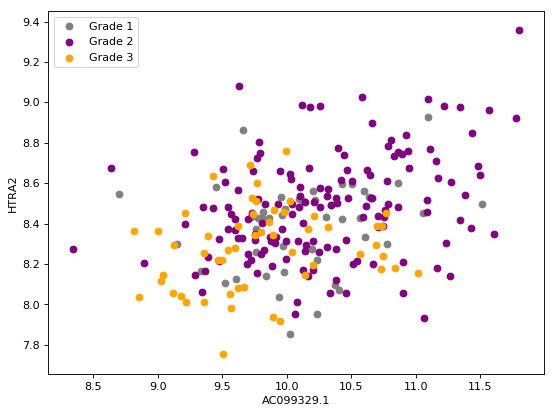

In [44]:
draw_two_features(data=expr_selected, index_list=[three_selected_list[0], three_selected_list[1]])

#### The Second Feature and The Third Feature

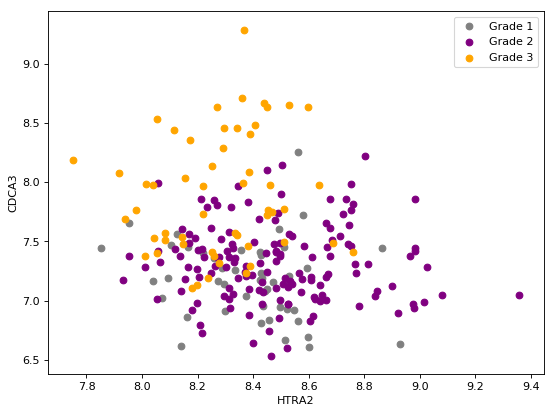

In [45]:
draw_two_features(data=expr_selected, index_list=[three_selected_list[1], three_selected_list[2]])

#### The First Feature and The Third Feature

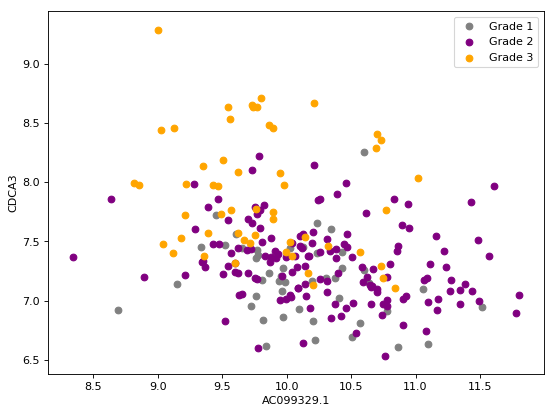

In [46]:
draw_two_features(data=expr_selected, index_list=[three_selected_list[0], three_selected_list[2]])

As a result of clustering using 2 features among top 3 features,  
we can see that the 246 data are very well clustered.

#### Best Three Features

In [47]:
from mpl_toolkits.mplot3d import Axes3D

def draw_three_features(data, index_list):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
    feature_name = (data.iloc[:, index_list].columns)
    
    grade_1_expr = data[clinical_preprocessed["grade"] == 1]
    grade_2_expr = data[clinical_preprocessed["grade"] == 2]
    grade_3_expr = data[clinical_preprocessed["grade"] == 3]

    # Grade 1
    xf = grade_1_expr.iloc[:, index_list[0]]
    yf = grade_1_expr.iloc[:, index_list[1]]
    zf = grade_1_expr.iloc[:, index_list[2]]

    ax.scatter(xf, yf, zf, color="grey", label="Grade 1", alpha=0.5)

    
    # Grade 2
    xf = grade_2_expr.iloc[:, index_list[0]]
    yf = grade_2_expr.iloc[:, index_list[1]]
    zf = grade_2_expr.iloc[:, index_list[2]]

    ax.scatter(xf, yf, zf, color="purple", label="Grade 2", alpha=0.5)
    
    # Grade 3
    xf = grade_3_expr.iloc[:, index_list[0]]
    yf = grade_3_expr.iloc[:, index_list[1]]
    zf = grade_3_expr.iloc[:, index_list[2]]
    
    ax.scatter(xf, yf, zf, color="orange", label="Grade 3", alpha=0.5)

    ax.set_xlabel(feature_name[0])
    ax.set_ylabel(feature_name[1])
    ax.set_zlabel(feature_name[2])
    
    plt.legend()
    plt.show()

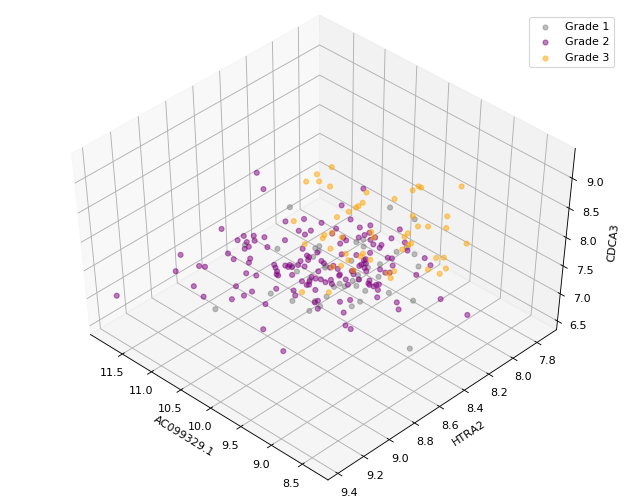

In [48]:
draw_three_features(data=expr_selected, index_list=three_selected_list)

Clustering of using top 3 features in 3D shows that all data are well clustered.

## (2) Selecting More Influential Features

Selecting the most influential features set.

### Finding More Influential Features

In [49]:
for i in range(len(sbs.subsets_)):
    i += 2
    
    subset_list = get_subset_of_count(sbs.subsets_, i)
    print("Feature index : ", subset_list)
    print("Size of feature set : ", len(subset_list))

    total_start = time.time()

    clf_final = LinearSVC(C=0.01, penalty='l1', dual=False)  # 0.009 ~ 0.010 사이에 있을 듯 함
    clf_final.fit(X_train_selected_std[:, subset_list], y_train_all)
    pred_final = clf_final.predict(X_test_selected_std[:, subset_list])

    acc_pca_best = accuracy_score(pred_final, y_test_all)


    total_end = time.time()

    total_elapsed_time = total_end - total_start

    print("Accuracy [{} features selected] : {}".format(i, acc_pca_best))
    print()

Feature index :  [11, 24]
Size of feature set :  2
Accuracy [2 features selected] : 0.74

Feature index :  [11, 19, 24]
Size of feature set :  3
Accuracy [3 features selected] : 0.74

Feature index :  [11, 19, 23, 24]
Size of feature set :  4
Accuracy [4 features selected] : 0.76

Feature index :  [0, 11, 19, 23, 24]
Size of feature set :  5
Accuracy [5 features selected] : 0.76

Feature index :  [0, 3, 11, 19, 23, 24]
Size of feature set :  6
Accuracy [6 features selected] : 0.78

Feature index :  [0, 3, 6, 11, 19, 23, 24]
Size of feature set :  7
Accuracy [7 features selected] : 0.76

Feature index :  [0, 2, 3, 6, 11, 19, 23, 24]
Size of feature set :  8
Accuracy [8 features selected] : 0.74

Feature index :  [0, 2, 3, 4, 6, 11, 19, 23, 24]
Size of feature set :  9
Accuracy [9 features selected] : 0.76

Feature index :  [0, 2, 3, 4, 5, 6, 11, 19, 23, 24]
Size of feature set :  10
Accuracy [10 features selected] : 0.76

Feature index :  [0, 2, 3, 4, 5, 6, 7, 11, 19, 23, 24]
Size of fe

Based on the above results,  
it will be selected only top 24 features to train.

In [50]:
subset_list = get_subset_of_count(sbs.subsets_, 24)
print(subset_list)

subset_expr = expr_selected.iloc[:, subset_list]
subset_expr.head()

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


,CD7,HEXIM1,TPI1P1,CYBRD1,ERBB4,DFFA,COX7C,MRPL15,BCL11A,SREK1,...,UBE2C,KIF4A,SATB1,SCUBE2,HTRA2,CIAO2B,PMP22,SLC25A5,WDR19,CDCA3
genename,,,,,,,,,,,,,,,,,,,,,
gsm282373,6.565177,7.766940,11.865740,8.661585,5.336498,8.041531,11.125007,10.443782,7.019233,8.880945,...,10.550188,7.613960,8.165178,6.214857,8.751152,9.799899,9.434325,12.604112,6.966100,7.766534
gsm282374,6.387481,8.663498,12.153245,6.243273,8.022628,8.352381,11.119565,9.967522,6.996163,9.122849,...,8.652794,6.691203,8.243053,6.522683,8.179052,9.821884,8.416905,11.565419,7.822283,7.104476
gsm282376,6.525703,8.236372,11.748491,9.298099,6.996714,7.733717,10.992404,9.997511,7.172960,9.763526,...,8.581016,6.848337,9.363831,7.891156,8.577786,9.396427,10.746947,12.324832,8.135081,7.183301
gsm282378,6.299117,8.484568,11.785456,8.432658,7.325697,7.770518,10.621926,10.507935,6.573437,9.561202,...,9.602270,7.544409,8.399486,11.297015,8.741746,9.380524,11.261228,12.043204,8.068822,7.476550
gsm282379,6.173453,8.525260,11.960539,7.053925,7.479351,7.723426,10.765772,11.214975,6.286423,9.117831,...,10.998169,8.036261,8.247969,10.976449,8.804110,10.251448,10.169798,11.991029,7.727159,8.219365


In [51]:
subset_expr.columns

Index(['CD7', 'HEXIM1', 'TPI1P1', 'CYBRD1', 'ERBB4', 'DFFA', 'COX7C', 'MRPL15',
       'BCL11A', 'SREK1', 'AC099329.1', 'LAMP3', 'TSC22D3', 'YBX1P1', 'UBE2C',
       'KIF4A', 'SATB1', 'SCUBE2', 'HTRA2', 'CIAO2B', 'PMP22', 'SLC25A5',
       'WDR19', 'CDCA3'],
      dtype='object')

In [52]:
total_start = time.time()

clf_influential_selected = LinearSVC(C=0.01, penalty='l1', dual=False)
clf_influential_selected.fit(X_train_selected_std[:, subset_list], y_train_selected)

total_end = time.time()

pred_influential_selected = clf_influential_selected.predict(X_test_selected_std[:, subset_list])

influential_scores = cross_val_score(estimator=clf_influential_selected,
                                     X=X_train_selected_std[:, subset_list],
                                     y=y_train_selected,
                                     cv=5,
                                     scoring='accuracy')

acc_influential_selected_best = accuracy_score(pred_influential_selected, y_test_selected)
influential_elapsed_time = total_end - total_start

print("Accuracy (SVM(linear) [Best Influential Features]) : {}".format(acc_influential_selected_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (influential_scores.mean(), influential_scores.std()))
print("Elapsed Time : {}".format(influential_elapsed_time))

Accuracy (SVM(linear) [Best Influential Features]) : 0.78
K-Fold scores: 0.66 (+/- 0.03)
Elapsed Time : 0.00299072265625


### Visualization of the Univariate Distribution from Each Feature

Checking 'Univariate Distribution' for 'grade' of top 24 most influential features,  
and then it will be make sure that they are obviously influential.

In [53]:
import seaborn as sns

def draw_axes(index, cdn):
    for i in range(3):
        i += 1
        if i == 1:
            c = "r"
            l = "Grade 1"
        elif i == 2:
            c = "g"
            l = "Grade 2"
        elif i == 3:
            c = "b"
            l = "Grade 3"

        sns.distplot(
            subset_expr[clinical_preprocessed["grade"] == i].iloc[:, index],
            hist=False,
            color=c,
            kde_kws={"shade": True},
            ax=axes[cdn],
            label=l
        )


def draw_sns(index):
    fig = plt.figure(figsize=(8, 4), dpi=80)
    
    for i in range(3):
        i += 1
        if i == 1:
            c = "r"
            l = "Grade 1"
        elif i == 2:
            c = "g"
            l = "Grade 2"
        elif i == 3:
            c = "b"
            l = "Grade 3"

        
        sns.distplot(
            subset_expr[clinical_preprocessed["grade"] == i].iloc[:, index],
            hist=False, 
            color=c,
            kde_kws={"shade": True},
            label=l
        )

    plt.ylabel("Univariate")
    plt.title("Univariate Distribution on Values") # You can comment this line out if you don't need title
    plt.legend()
    plt.show(fig)

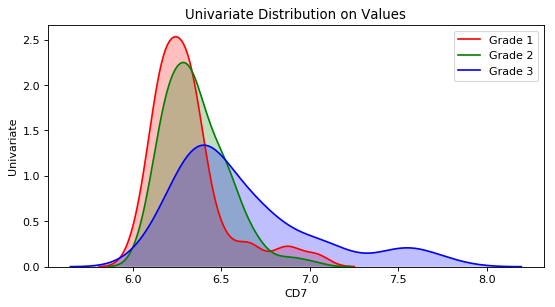

In [54]:
draw_sns(0)

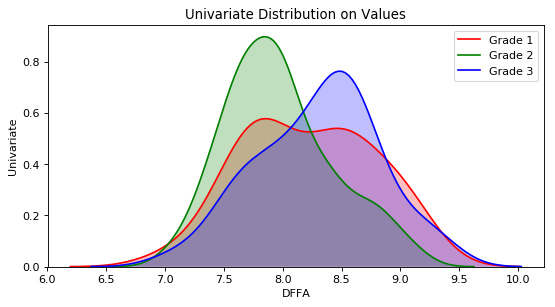

In [55]:
draw_sns(5)

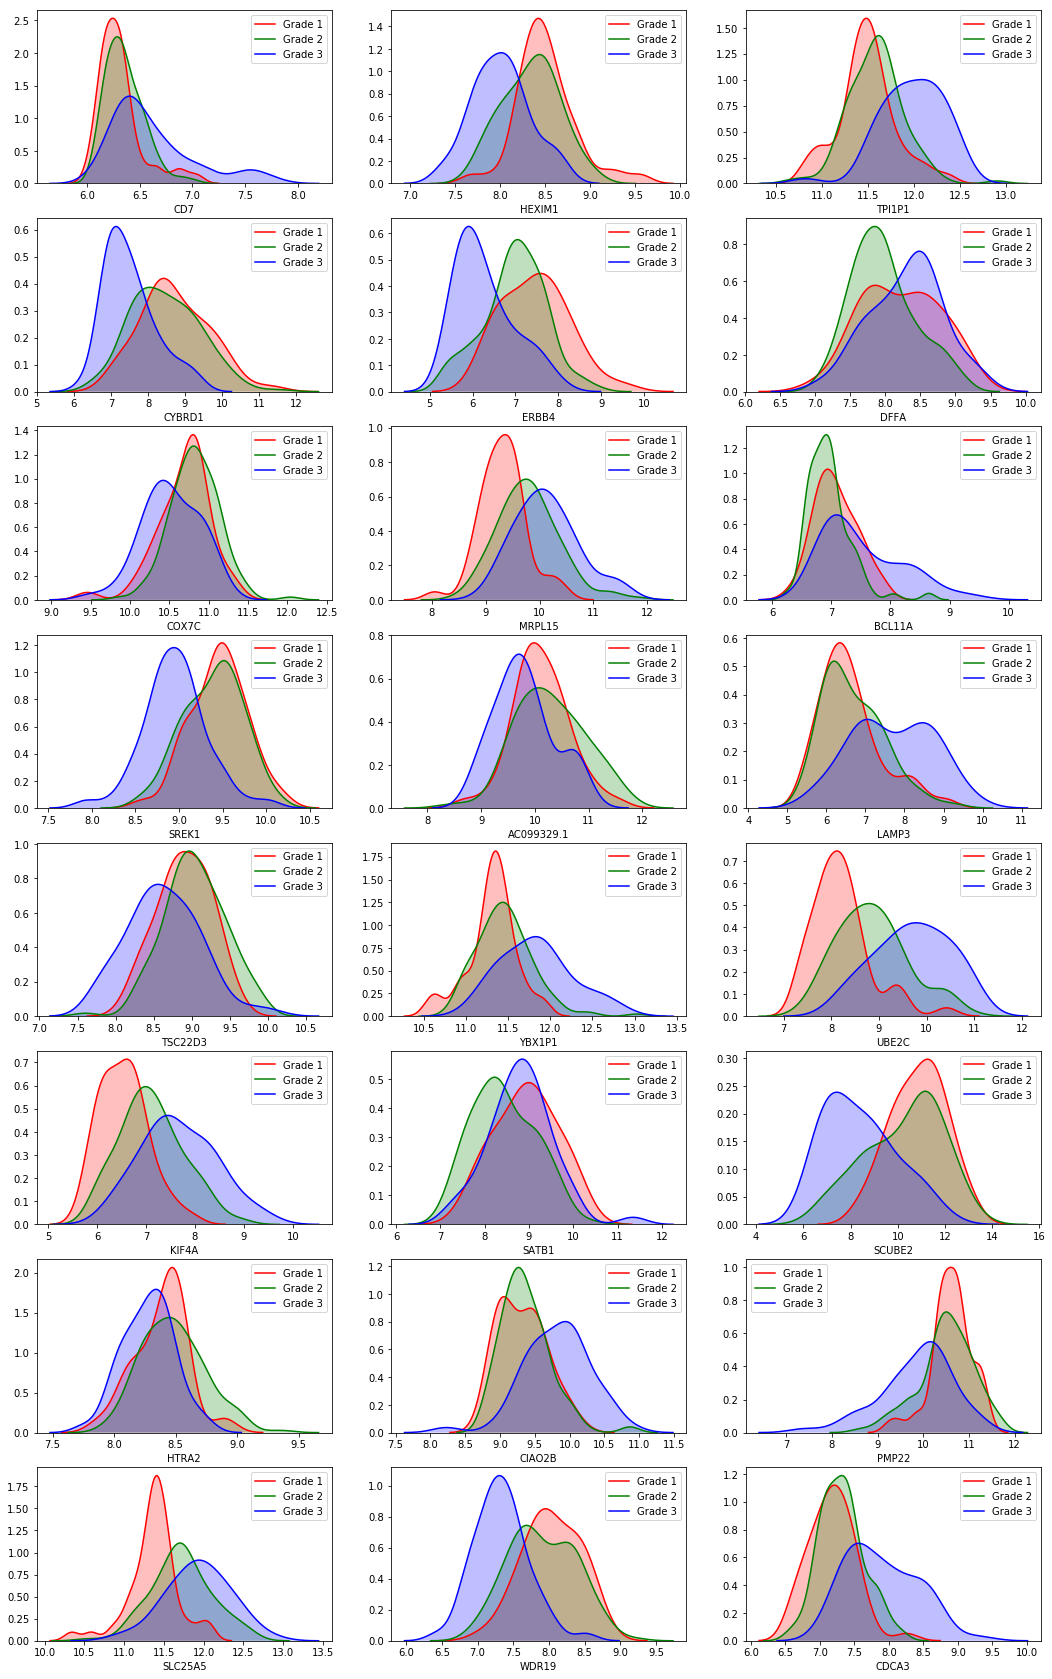

In [56]:
gene_list = subset_expr.columns

f, axes = plt.subplots(8, 3, figsize=(18, 30), sharex=False)

for i in range(len(gene_list)):
    q = int(i / 3)
    r = int(i % 3)
    draw_axes(index=i, cdn=(q, r))

As a result of looking at the 'Univariate Distribution' of top 24 selected features,  
most of selected features are seen to have a somewhat divided shape.

_(And I trained with top 24 selected features, but the accuracy and k-fold scores did not improve, but also have same value)_

---

# 5 - 2. Compressing Features using PCA

Compressing 28 features selected in __"4. Selecting Features"__ using PCA.
  
If selected features are obviously influential,  
it will be had better-divided clustering by eigenvalues than original selected features.

### Compressing Features using PCA

In [57]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    expr_selected, 
    list(clinical_preprocessed["grade"]), 
    test_size=0.2, 
    random_state=1
)

In [58]:
scaler = StandardScaler()
X_train_pca_std = scaler.fit_transform(X_train_pca)
X_test_pca_std = scaler.transform(X_test_pca)

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_pca_std)

Drawing the graph of accuracy according to 'n_component' when converted to PCA.

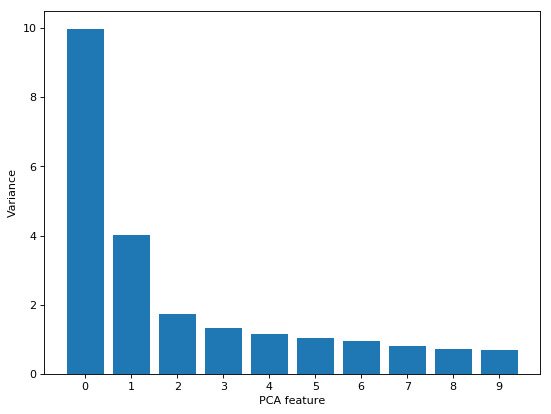

In [60]:
# Drawing the graph of accuracy according to 'n_component' when converted to PCA.
features = range(pca.n_components_)

plt.figure(figsize=(8, 6), dpi=80)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show()

### Training PCA data with n_components == 1

In [61]:
pca_n = PCA(n_components=1)
X_pca_train_data = pca_n.fit_transform(X_train_pca_std)
X_pca_test_data = pca_n.transform(X_test_pca_std)

In [62]:
total_start = time.time()

clf_pca = LinearSVC(C=0.01, penalty='l1', dual=False)
clf_pca.fit(X_pca_train_data, y_train_pca)

total_end = time.time()

pred_pca = clf_pca.predict(X_pca_test_data)

pca_scores = cross_val_score(estimator=clf_pca,
                             X=X_pca_train_data,
                             y=y_train_pca,
                             cv=5,
                             scoring='accuracy')

acc_pca_best = accuracy_score(pred_pca, y_test_pca)
pca_elapsed_time = total_end - total_start

print("Accuracy (SVM(linear)) [PCA] : {}".format(acc_pca_best))
print("K-Fold scores: %0.2f (+/- %0.2f)"% (pca_scores.mean(), pca_scores.std()))
print("Elapsed Time : {}".format(pca_elapsed_time))

Accuracy (SVM(linear)) [PCA] : 0.68
K-Fold scores: 0.69 (+/- 0.05)
Elapsed Time : 0.0009982585906982422


### Visualization of Clustering using Compressed Features from PCA

#### Best Two in PCA

In [63]:
def draw_two_pca(data, index_list):
    plt.figure(figsize=(8, 6), dpi=80)
    
    grade_1_expr = pd.DataFrame(data[[clinical_preprocessed["grade"] == 1]])
    grade_2_expr = pd.DataFrame(data[clinical_preprocessed["grade"] == 2])
    grade_3_expr = pd.DataFrame(data[clinical_preprocessed["grade"] == 3])

    # Grade 1
    xf = grade_1_expr.iloc[:, index_list[0]]
    yf = grade_1_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="grey", label="Grade 1")
    
    # Grade 2
    xf = grade_2_expr.iloc[:, index_list[0]]
    yf = grade_2_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="purple", label="Grade 2")
    
    # Grade 3
    xf = grade_3_expr.iloc[:, index_list[0]]
    yf = grade_3_expr.iloc[:, index_list[1]]

    plt.scatter(xf, yf, color="orange", label="Grade 3")

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.show()

In [64]:
# Confirming 2D Clustering
scaler = StandardScaler()
subset_expr_scaled = scaler.fit_transform(expr_selected)

pca_two = PCA(n_components=2)
pca_two_features = pca_two.fit_transform(subset_expr_scaled)

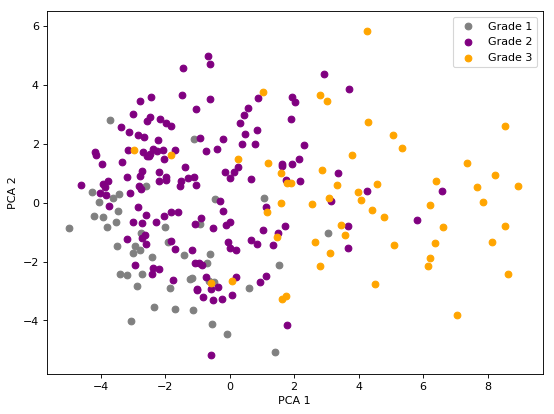

In [65]:
draw_two_pca(data=pca_two_features, index_list=[0, 1])

#### Best Three in PCA

In [66]:
def draw_three_pca(data, index_list):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
    grade_1_expr = pd.DataFrame(data[clinical_preprocessed["grade"] == 1])
    grade_2_expr = pd.DataFrame(data[clinical_preprocessed["grade"] == 2])
    grade_3_expr = pd.DataFrame(data[clinical_preprocessed["grade"] == 3])

    # Grade 1
    xf = grade_1_expr.iloc[:, index_list[0]]
    yf = grade_1_expr.iloc[:, index_list[1]]
    zf = grade_1_expr.iloc[:, index_list[2]]

    ax.scatter(xf, yf, zf, color="grey", label="Grade 1", alpha=0.5)

    
    # Grade 2
    xf = grade_2_expr.iloc[:, index_list[0]]
    yf = grade_2_expr.iloc[:, index_list[1]]
    zf = grade_2_expr.iloc[:, index_list[2]]

    ax.scatter(xf, yf, zf, color="purple", label="Grade 2", alpha=0.5)
    
    # Grade 3
    xf = grade_3_expr.iloc[:, index_list[0]]
    yf = grade_3_expr.iloc[:, index_list[1]]
    zf = grade_3_expr.iloc[:, index_list[2]]
    
    ax.scatter(xf, yf, zf, color="orange", label="Grade 3", alpha=0.5)

    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    
    plt.legend()
    plt.show()

In [67]:
# Confirming 3D Clustering
pca_three = PCA(n_components=3)
pca_three_features = (pca_three.fit_transform(subset_expr_scaled))

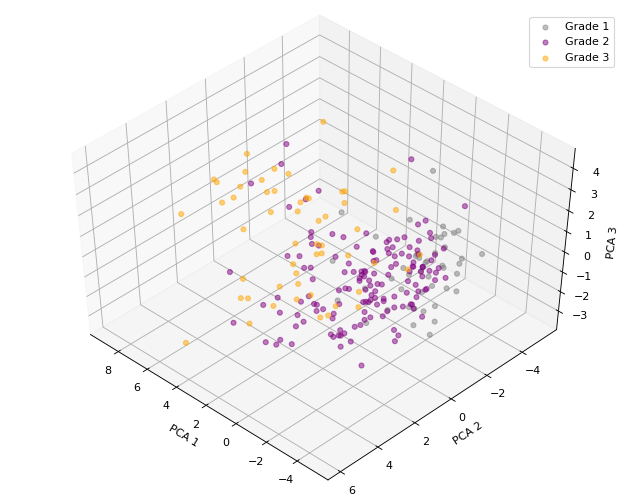

In [68]:
draw_three_pca(data=pca_three_features, index_list=[0, 1, 2])

When looking at data clustered with PCA compressed features,  
we can see that the boundary of the classification is more clear than when it is not compressed.

---

# 6. Summary

### The Summary Table about All of Classifiers

In [69]:
summary_label = ["Default Linear SVM", "Best Params", "Selected Features", "Best Three Features", "Best Influential Features", "PCA"]
accuracy_list = [acc_svm_linear, acc_svm_linear_best, acc_selected_best, acc_three_selected_best, acc_influential_selected_best, acc_pca_best]
k_fold_mean_list = [svm_linear_scores.mean(), svm_linear_best_scores.mean(), selected_scores.mean(), three_selected_scores.mean(), influential_scores.mean(), pca_scores.mean()]
k_fold_std_list = [svm_linear_scores.std(), svm_linear_best_scores.std(), selected_scores.std(), three_selected_scores.std(), influential_scores.std(), pca_scores.std()]
elapsed_time_list = [svm_elapsed_time, best_svm_elapsed_time, selected_elapsed_time, three_elapsed_time, influential_elapsed_time, pca_elapsed_time]
feature_size_list = [len(X_train_all_std[0]), len(X_train_all_std[0]), len(X_train_selected_std[0]), len(X_train_selected_std[:, three_selected_list][0]), len(X_train_selected_std[:, subset_list][0]), len(X_pca_train_data[0])]

k_fold_list = [str(round(km, 2)) + " (+/- " for km in k_fold_mean_list]
for i in range(len(k_fold_list)):
    k_fold_list[i] += (str(round(k_fold_std_list[i], 2)) + ")") 

summary_table_data = {"Classifier": summary_label,
                      "Accuracy": accuracy_list,
                      "K-Fold Score": k_fold_list,
                      "Elapsed Time": elapsed_time_list,
                      "Feature Size": feature_size_list}

summary_table = pd.DataFrame(data=summary_table_data)
summary_table.index = summary_table["Classifier"]
del summary_table["Classifier"]

In [70]:
summary_table

,Accuracy,K-Fold Score,Elapsed Time,Feature Size
Classifier,,,,
Default Linear SVM,0.62,0.61 (+/- 0.06),0.563493,13013
Best Params,0.78,0.62 (+/- 0.03),0.503653,13013
Selected Features,0.78,0.64 (+/- 0.04),0.003989,28
Best Three Features,0.74,0.66 (+/- 0.03),0.000998,3
Best Influential Features,0.78,0.66 (+/- 0.03),0.002991,24
PCA,0.68,0.69 (+/- 0.05),0.000998,1


### The List of Found Influential Genes

In [71]:
print("The number of found influential genes : {}".format(len(expr_selected.columns)))
tuple(expr_selected.columns)

The number of found influential genes : 28


('CD7',
 'LRP8',
 'HEXIM1',
 'TPI1P1',
 'CYBRD1',
 'ERBB4',
 'DFFA',
 'COX7C',
 'MRPL15',
 'BCL11A',
 'SREK1',
 'AC099329.1',
 'LAMP3',
 'TSC22D3',
 'YBX1P1',
 'UBE2C',
 'KIF4A',
 'SATB1',
 'SCUBE2',
 'HTRA2',
 'CIAO2B',
 'PMP22',
 'SLC25A5',
 'WDR19',
 'CDCA3',
 'TMEM39B',
 'COX5A',
 'MLPH')

___At last, I tried to apply 'Ensemble Method' using various classifiers (Logistic Regression, Decision Tree, KNN, etc ...),  
but there is no performance improvement.___

---

# 7. Conclusion

Through the preprocessed 246 data, a model has 78% accuracy and training speed of about 0.003 (ms) was obtained (in my PC).  
I think that it is meaningful to have about 78% accuracy when training only most efficient and influential 24 genes out of 13013 genes in only 246 dataset.  
And I think it's also meaningful that the data were clustered well enough to be seen easy by eyes.  

If the dataset grows, I guess we will be got the more efficient model with very high accuracy and fast speed to train.  

I hope that this result would be contributed to research for finding genes that affect breast cancer.

---

# + Found Influential Genes

These are data that have been searched for some paper on genes derived from __"4. Selecting Features".__

A list of genes that have relevant papers about breast cancer.

'HEXIM1' : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3136650/  
'SCUBE2' : https://www.ncbi.nlm.nih.gov/pubmed/24213532  
'CYBRD1' : https://www.researchgate.net/publication/311944229_Tumor-initiating_cells_of_breast_and_prostate_origin_show_alterations_in_the_expression_of_genes_related_to_iron_metabolism  
'PMP22' : https://bmccancer.biomedcentral.com/articles/10.1186/1471-2407-10-682  
'ERBB4' : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4763414/  
'LRP8' : https://www.ncbi.nlm.nih.gov/pubmed/30227220  
'CDCA3' : https://www.ncbi.nlm.nih.gov/pubmed/29467944  
'SATB1' : https://www.ncbi.nlm.nih.gov/pubmed/27161300  
'LAMP3' : https://www.ncbi.nlm.nih.gov/pubmed/24434718  
'KIF4A' : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4255101/  
'BCL11A' : https://www.nature.com/articles/ncomms6987  
'MLPH' : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4666521/  
'UBE2C' : https://cancerci.biomedcentral.com/articles/10.1186/s12935-017-0455-1  

A list of genes that doesn't have relevant papers about breast cancer.

'TPI1P1'  
'HTRA2'  
'SREK1'  
'DFFA'  
'MRPL15'  
'COX7C'  
'SLC25A5'  
'COX5A'  
'TSC22D3'  
'WDR19'  
'YBX1P1'  
'CD7'  
'AC099329.1'  
'CIAO2B'  
'TMEM39B'  

About 55% of the derived genes are related with breast cancer.  
Genes that don't have any related paper may need more research, or may not be related with the cancer.